In [1]:
import math
import torch
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from sklearn.datasets import load_iris
import itertools

from lunanlp import ram

import seaborn
import matplotlib.pyplot as plt
from plotutil import PlotLayout

In [24]:
x = torch.rand(64, 128)
init.normal_(x, 0, 1)
print(x.mean(), x.var())

tensor(-0.0140) tensor(1.0206)


In [30]:
# act = lambda x: x / (1 + torch.abs(x))
x = torch.rand(1, 1024)
init.normal_(x, 0, 1)
act = torch.tanh
print(act(x).mean(), act(x).var())

tensor(0.0089) tensor(0.3802)


### Linear

The input of the network is a vector $x$ which satisfies:

$$
\begin{aligned}
x \in & \mathbb{R}^{n} \\
\mathbb{E}[x] = & 0 \\
\mathbb{VAR}[x] = & 1 \\
\end{aligned}
$$

For each layer, we want to find a weight which satisfies:

$$
\begin{aligned}
W \in & \mathbb{R}^{n \times m} \\
y = x W \in & \mathbb{R}^{m} \\
\mathbb{E}[y] = & 0 \\
\mathbb{VAR}[y] = & 1 \\
\end{aligned}
$$

Note that the components of $x$ and $W$ are sampled independently from some distribution $p(x)$, we set the mean of $W$ to $0$ since it will produce an output with zero-mean:

$$
\begin{aligned}
\mathbb{E}[y_i] = & \mathbb{E}[\sum_j x_i W_{ij}] \\
= & n \times \mathbb{E}[x_i W_{ij}] \\
= & n \times \mathbb{E}[x_i] \times \mathbb{E}[W_{ij}] \\
= & 0
\end{aligned}
$$

For a random variable whose mean is $0$, its variance is equal to the second-order momentum.

$$
\mathbb{VAR}[x] \equiv \mathbb{E}[x^2] - \mathbb{E}[x]^2 = \mathbb{E}[x^2]
$$

$$
\begin{aligned}
\mathbb{VAR}[y_i]
= & \mathbb{E}[y_i^2] \\
= & \mathbb{E}[\sum_j ( x_i W_{ij} )^2] \\
\approx & \mathbb{E}[ n ( x_i W_{ij} )^2 ] \\
= & n \times \mathbb{E}[x_i^2  W_{ij}^2 ] \\
= & n \times \mathbb{E}[x_i^2] \times \mathbb{E}[W_{ij}^2 ] \\
= & n \times \mathbb{VAR}[x] \times \mathbb{VAR}[W] \\
= & n \times 1 \times \mathbb{VAR}[W]
\end{aligned}
$$

Set $\mathbb{VAR}[y] = 1$, we will get:
$$
\mathbb{VAR}[W] = 1 / n
$$

In [202]:
net = torch.nn.Sequential(
    torch.nn.Linear(128, 64, bias=False),
    torch.nn.Linear(64, 32, bias=False),
)
init.normal_(net[0].weight, 0, math.sqrt(1/128))
init.normal_(net[1].weight, 0, math.sqrt(1/64))

y = net(x)
print(y.mean(), y.var())

tensor(-0.0146, grad_fn=<MeanBackward0>) tensor(0.9577, grad_fn=<VarBackward0>)


### ReLU

For a neural network which contains `ReLU`,

$$
\begin{aligned}
\mathbb{VAR}[y_i]
= & \mathbb{E}[y_i^2] \\
= & \mathbb{E}[\sum_j ( \mathrm{ReLU}( x_i ) W_{ij}  )^2] \\
\approx & \mathbb{E}[ \frac{n}{2} \times ( x_i W_{ij} )^2 ] \\
= & \frac{n}{2} \times \mathbb{E}[x_i^2  W_{ij}^2 ] \\
= & \frac{n}{2} \times \mathbb{E}[x_i^2] \times \mathbb{E}[W_{ij}^2 ] \\
= & \frac{n}{2} \times \mathbb{VAR}[x] \times \mathbb{VAR}[W] \\
= & \frac{n}{2} \times 1 \times \mathbb{VAR}[W]
\end{aligned}
$$

Set $\mathbb{VAR}[y] = 1$, we will get:
$$
\mathbb{VAR}[W] = 2 / n
$$


In [203]:
net = torch.nn.Sequential(
    torch.nn.Linear(128, 64, bias=False),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 32, bias=False),
)
init.normal_(net[0].weight, 0, math.sqrt(1/128))
init.normal_(net[2].weight, 0, math.sqrt(2/64))

y = net(x)
print(y.mean(), y.var())

tensor(-0.0858, grad_fn=<MeanBackward0>) tensor(0.9669, grad_fn=<VarBackward0>)


### Sigmoid

For a neural network which contains `Sigmoid`:

$$
\begin{aligned}
\mathbb{VAR}[y_i]
= & \mathbb{E}[y_i^2] \\
= & \mathbb{E}[\sum_j ( \mathrm{Sigmoid}( x_i ) W_{ij}  )^2] \\
\approx & \mathbb{E}[ n \times ( s_i W_{ij} )^2 ] \\
= & n \times \mathbb{E}[s_i^2  W_{ij}^2 ] \\
= & n \times \mathbb{E}[s_i^2] \times \mathbb{E}[W_{ij}^2 ] \\
= & n \times \mathbb{E}[\mathrm{Sigmoid}(\mu=0, \sigma^2=1)^2] \times \mathbb{VAR}[W] \\
\approx & n \times 0.5 \times \mathbb{VAR}[W]  
\mathrm{~~~\cdots~MCMC}
\end{aligned}
$$

Set $\mathbb{VAR}[y] = 1$, we will get:

$$
\mathbb{VAR}[W] = 2 / n
$$


In [361]:
x_mcmc = torch.rand(1024)
init.normal_(x_mcmc, 0, 1)

x_mcmc = torch.rand(128, 128)
init.normal_(x_mcmc, 0, 1)
torch.sigmoid(net[0](x_mcmc)).square().mean()

tensor(0.4935, grad_fn=<MeanBackward0>)

In [419]:
net = torch.nn.Sequential(
    torch.nn.Linear(128, 64, bias=False),
    torch.nn.Sigmoid(),
    torch.nn.Linear(64, 32, bias=False),
)
init.normal_(net[0].weight, 0, math.sqrt(128))
init.normal_(net[2].weight, 0, math.sqrt(2/64))

y = net(x)
print(y.mean(), y.var())

tensor(0.1387, grad_fn=<MeanBackward0>) tensor(0.7528, grad_fn=<VarBackward0>)


### Real Case

In [89]:
class CustomDataset(Dataset):
    def __init__(self) -> None:
        super().__init__()
        self.data = load_iris()
        
    def __len__(self):
        return len(self.data['data'])
        
    def __getitem__(self, index):
        x = self.data['data'][index]
        x = torch.cat([torch.tensor(x, dtype=torch.float32) for _ in range(32)])
        x = torch.layer_norm(x, x.shape)
        y = torch.tensor(self.data['target'][index])
        return x, y

data = DataLoader(CustomDataset(), batch_size=4)
next(iter(data))[0].shape

torch.Size([4, 128])

In [137]:
ram.reset()
ram.list_keys()

def build_forward_hook(idx):
    def forward_hook(module, input_seq, output):
        ram.append(f'fw.norm{idx}', output.data.norm().item())
        ram.append(f'fw.mean{idx}', output.data.mean().item())
        ram.append(f'fw.var{idx}',  output.data.var().item())
    return forward_hook

def build_backward_hook(idx):
    def backward_hook(module, input_seq, output_seq):
        ram.append(f'bw.norm{idx}', output_seq[0].data.norm().item())
        ram.append(f'bw.mean{idx}', output_seq[0].data.mean().item())
        ram.append(f'bw.var{idx}',  output_seq[0].data.var().item())
    return backward_hook


net = torch.nn.Sequential(
    torch.nn.Linear(128, 64, bias=False),
    *[torch.nn.Linear(64, 64, bias=False) for _ in range(6)],
    torch.nn.Linear(64, 3, bias=False),
)
for i, layer in enumerate(net):
    init.uniform_(layer.weight, -math.sqrt(6/(layer.in_features + layer.out_features)), math.sqrt(6/(layer.in_features + layer.out_features)))
    init.normal_(layer.weight, 0, math.sqrt(1/layer.in_features))
    # init.normal_(layer.weight, 0, 0.02)
    layer.register_forward_hook(build_forward_hook(i))
    layer.register_full_backward_hook(build_backward_hook(i))

In [138]:
opt = torch.optim.SGD(net.parameters(), lr=0.01)
# opt = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
# opt = torch.optim.AdamW(net.parameters(), lr=0.001,)

for bid, batch in enumerate(itertools.cycle(data)):
    x, y = batch
    opt.zero_grad()
    p = net(x)
    loss = F.cross_entropy(p, y)
    loss.backward()
    opt.step()
    
    ram.append(f'loss', loss.item())
        
    if bid == 200:
        break

allocating 4 rows x 2 cols for 8 subplots.


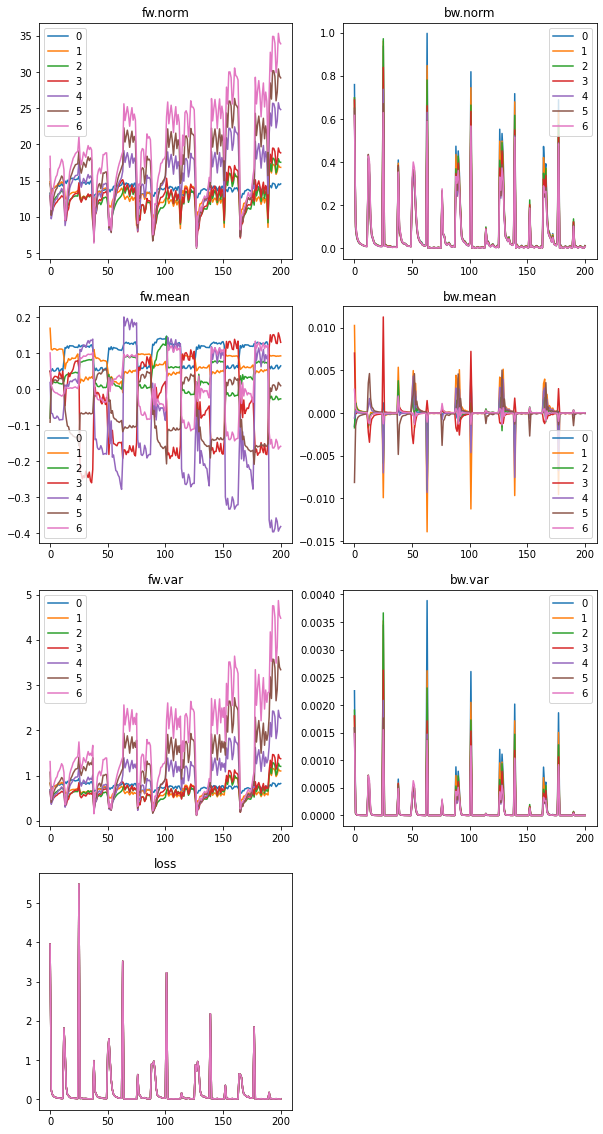

In [139]:
layout = PlotLayout(plt, 8, 4)
layout.prepare()

keys = ['fw.norm', 'bw.norm', 'fw.mean', 'bw.mean', 'fw.var', 'bw.var']

for key_idx, key in enumerate(keys):
    layout.subplot(key_idx)
    plt.title(key)
    for layer_idx in range(7):
        plt.plot(range(len(ram.read(f'{key}{layer_idx}'))), ram.read(f'{key}{layer_idx}'))
        plt.legend(list(range(7)))
            
layout.subplot(6)
plt.title('loss')
for i in range(7):
    plt.plot(range(len(ram.read(f'loss'))), ram.read(f'loss'))